In [1]:
# Import Packages
import torch
import torch.optim as optim
import torch.nn.functional as F
import ray
from torch import nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from torchinfo import summary
import seaborn as sns
import pandas as pd


Train: 54000
Test: 10000
Val 6000


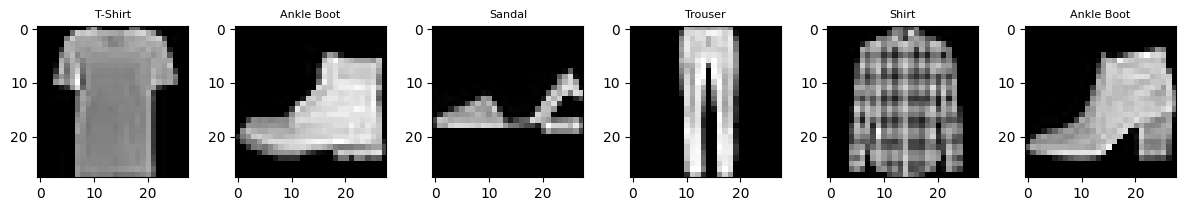

In [ ]:
# Load Dataset and Preprocessing:

trainTransform = transforms.Compose([ # Add data augmentation to training data 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainData = datasets.FashionMNIST( # Loads Train data of the FashionMNIST dataset
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testData = datasets.FashionMNIST(  # Loads Test  data of the FashionMNIST dataset
    root="data",
    train=False,
    download=True,
    transform=testTransform
)

train = int(0.9 * len(trainData))  # 90% for training
val = len(trainData) - train   # 10% for validation

trainData, valData = random_split(trainData, [train, val]) # Validation split

trainData.dataset.transform = trainTransform  # Augment only training data
valData.dataset.transform = testTransform   

classNames = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

print("Train:", len(trainData))
print("Test:", len(testData))
print("Val", len(valData))

# Show first few images

fig, axes = plt.subplots(1, 6, figsize=(12, 2)) 

for i in range(6):
    img, label = trainData[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(classNames[label], fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# ANN Model:

class ANN(nn.Module):
    def __init__(self, inputSize=28*28, hiddenSizes=[1024, 512, 256], dropoutRate=0.2, BN=True):
        super().__init__()
        self.flatten = nn.Flatten() # Flatten input
        self.relu = nn.ReLU() # Activation function

        layers = []
        for h in hiddenSizes: # Use hyperparameter tuning for different number and sizes of hidden layers
            layers.append(nn.Linear(inputSize, h))
            if BN: # Batch Normalization
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropoutRate)) # Add dropout layers
            inputSize = h

        layers.append(nn.Linear(inputSize, 10))
        self.model = nn.Sequential(*layers)

    def forward(self, x): # Forward pass through the model
        x = self.flatten(x)
        x = self.model(x)
        return x


In [ ]:
# CNN Model:

class CNN(nn.Module):
    def __init__(self, dropoutRate=0.2, convLayers=(32, 64, 128), BN=True):
        super().__init__()
        self.relu = nn.ReLU() # Activation function

        layers = []
        inputSize = 1
        for f in convLayers: # Use Hyperparameter tuning for different number and sizes of convolutional layers
            layers.append(nn.Conv2d(inputSize, f, kernel_size=3, padding=1))
            if BN: # Batch Normalization
                layers.append(nn.BatchNorm2d(f))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2, 2)) # Max Pooling layer
            layers.append(nn.Dropout(dropoutRate)) # Dropout layer
            inputSize = f

        self.convModel = nn.Sequential(*layers)

        self.flattenedSize = self._get_flattened_size((1, 28, 28))

        self.fc1 = nn.Linear(self.flattenedSize, 64) # Fully connected layers
        self.fc2 = nn.Linear(64, 10)


    def _get_flattened_size(self, shape): # Calculate flattened size after conv layers from hyperparamter tuning
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.convModel(x)
            return x.numel()


    def forward(self, x): # Forward pass through the model
        x = self.convModel(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# Tuning function to test hyperparameters

def modelTune(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set to train on the GPU

    if config["modelName"] == "CNN": # Select model based on config
        model_class = CNN
        model_args = { # Set model hyperparams
            "dropoutRate": config["dropout"],
            "convLayers": config["convLayers"],
        }
    elif config["modelName"] == "ANN":
        model_class = ANN
        model_args = {
            "inputSize": 28*28,
            "hiddenSizes": config["hiddenSizes"],
            "dropoutRate": config["dropout"]
        }

    model = model_class(**model_args).to(device) # Create the model with the hyperparameters

    optimizer = config['optimizer'](model.parameters(), lr=config['lr'], weight_decay=config['weightDecay'])
    criterion = nn.CrossEntropyLoss()

    trainLoader = DataLoader(config['trainData'], batch_size=config['batchSize'], shuffle=True)
    valLoader = DataLoader(config['valData'], batch_size=config['batchSize'], shuffle=False)

    for epoch in range(config['epochs']):
        runningLoss = 0.0
        epochSteps = 0
        for inputs, labels in trainLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Record statistics
            runningLoss += loss.item()
            epochSteps += 1

        # Validation loss
        valLoss = 0.0
        valSteps = 0
        total = 0
        correct = 0
        for inputs, labels in valLoader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                valLoss += loss.cpu().numpy()
                valSteps += 1
    tune.report({"loss": valLoss/valSteps, "accuracy": correct/total})


In [ ]:
import logging

ray.init(ignore_reinit_error=True, log_to_driver=False)
logging.getLogger("ray.tune").setLevel(logging.ERROR) # Disable logging

def short_trial_name(trial):
    return f"trial_{trial.trial_id}"


CNNconfig = { # Hyperparameter tuning config for CNN
    "modelName": "CNN",
    "trainData": trainData,
    "valData": valData,
    "convLayers": tune.choice([
        (32, 64),          # 2 conv layers
        (32, 64, 128),    # 3 conv layers
        (64, 128, 256)    # 3 conv layers
    ]),
    "dropout": tune.choice([0.1, 0.2, 0.3, 0.4]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batchSize": tune.choice([32, 64, 128]),
    "epochs": 15,
    "optimizer": tune.choice([torch.optim.Adam, torch.optim.SGD]),
    "weightDecay": tune.loguniform(1e-6, 1e-2) # L2 regularization

}
ANNconfig = {
    "modelName": "ANN",
    "trainData": trainData,
    "valData": valData,
    "hiddenSizes": tune.choice([
        [512, 256],          # 2 layers
        [1024, 512, 256],    # 3 layers
        [1024, 512, 256, 128] # 4 layers
    ]),
    "dropout": tune.choice([0.1, 0.2, 0.3, 0.4]),
    "lr": tune.loguniform(1e-5, 1e-1),
    "batchSize": tune.choice([32, 64, 128]),
    "epochs": 15,
    "optimizer": tune.choice([torch.optim.Adam, torch.optim.SGD]),
    "weightDecay": tune.loguniform(1e-6, 1e-2) # L2 regularization

}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=15, 
    grace_period=2,
    reduction_factor=2,
)



2025-11-03 18:42:30,434	INFO worker.py:2013 -- Started a local Ray instance.
c:\Users\Aidan\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\worker.py:2052: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [ ]:
# CNN tuning
cnnResult = tune.run(
    partial(modelTune),
    resources_per_trial={"cpu": 2, "gpu": 0.5},
    config=CNNconfig,
    num_samples=30,
    scheduler=scheduler,
    trial_dirname_creator=short_trial_name,
    verbose=0,
)

# Test different sets of hyperparameters to find the best set to avoid overfitting

CNNSorted = sorted( # Sort all trials by loss
    cnnResult.trials,
    key=lambda t: t.last_result["loss"]
)

print("\n=== CNN Trial Summary ===") # Print a summary of all trials in order
for i, trial in enumerate(CNNSorted, 1):
    cfg = trial.config
    res = trial.last_result

    print(
        f"{i:02d}. {trial.trial_id} | "
        f"loss: {res['loss']:.4f} | "
        f"acc: {res['accuracy']:.4f} | "
        f"dropout: {cfg['dropout']} | "
        f"lr: {cfg['lr']:.5f} | "
        f"batch: {cfg['batchSize']} | "
        f"convLayers: {cfg['convLayers']} | "
        f"weightDecay: {cfg['weightDecay']} | "
        f"optimizer: {cfg['optimizer'].__name__}"
    )

bestCNNTrial = cnnResult.get_best_trial("loss", "min", "last") # Get the best set of hyperparameters from the best trial
bestCNNConfig = bestCNNTrial.config



=== CNN Trial Summary ===
01. dd06a_00009 | loss: 0.2282 | acc: 0.9198 | dropout: 0.3 | lr: 0.00130 | batch: 64 | convFilters: (64, 128, 256) | weightDecay: 7.771007775877783e-06 | optimizer: Adam
02. dd06a_00027 | loss: 0.2356 | acc: 0.9137 | dropout: 0.1 | lr: 0.02432 | batch: 128 | convFilters: (64, 128, 256) | weightDecay: 1.5451331835130341e-06 | optimizer: SGD
03. dd06a_00028 | loss: 0.2380 | acc: 0.9163 | dropout: 0.1 | lr: 0.06363 | batch: 128 | convFilters: (32, 64, 128) | weightDecay: 0.00081702996079679 | optimizer: SGD
04. dd06a_00004 | loss: 0.2403 | acc: 0.9228 | dropout: 0.1 | lr: 0.00082 | batch: 32 | convFilters: (64, 128, 256) | weightDecay: 4.5328183663921654e-05 | optimizer: Adam
05. dd06a_00023 | loss: 0.2516 | acc: 0.9212 | dropout: 0.1 | lr: 0.00210 | batch: 32 | convFilters: (32, 64, 128) | weightDecay: 3.4654766552084114e-06 | optimizer: Adam
06. dd06a_00018 | loss: 0.2539 | acc: 0.9078 | dropout: 0.3 | lr: 0.00177 | batch: 32 | convFilters: (32, 64) | weightD

In [ ]:
# ANN tuning
annResult = tune.run(
    partial(modelTune),
    resources_per_trial={"cpu": 2, "gpu": 0.5},
    config=ANNconfig,
    num_samples=30,
    scheduler=scheduler,
    trial_dirname_creator=short_trial_name,
    verbose=0,
)

ANNSorted = sorted(
    annResult.trials,
    key=lambda t: t.last_result["loss"]
)

print("\n=== ANN Trial Summary ===") # Print a summary of all trials in order
for i, trial in enumerate(ANNSorted, 1):
    cfg = trial.config
    res = trial.last_result

    print(
        f"{i:02d}. {trial.trial_id} | "
        f"loss: {res['loss']:.4f} | "
        f"acc: {res['accuracy']:.4f} | "
        f"dropout: {cfg['dropout']} | "
        f"lr: {cfg['lr']:.5f} | "
        f"batch: {cfg['batchSize']} | "
        f"hiddenSizes: {cfg['hiddenSizes']} | "
        f"weightDecay: {cfg['weightDecay']} | "
        f"optimizer: {cfg['optimizer'].__name__}"
    )


bestANNTrial = annResult.get_best_trial("loss", "min", "last") # Get the best set of hyperparameters from the best trial
bestANNConfig = bestANNTrial.config



=== ANN Trial Summary ===
01. 2b320_00020 | loss: 0.3034 | acc: 0.8893 | dropout: 0.3 | lr: 0.00016 | batch: 128 | hiddenSizes: [1024, 512, 256] | weightDecay: 6.405419922307353e-06 | optimizer: Adam
02. 2b320_00007 | loss: 0.3046 | acc: 0.8938 | dropout: 0.2 | lr: 0.00004 | batch: 64 | hiddenSizes: [1024, 512, 256] | weightDecay: 0.00017213266281703566 | optimizer: Adam
03. 2b320_00024 | loss: 0.3139 | acc: 0.8863 | dropout: 0.3 | lr: 0.00041 | batch: 128 | hiddenSizes: [512, 256] | weightDecay: 0.00011371137091935187 | optimizer: Adam
04. 2b320_00005 | loss: 0.3146 | acc: 0.8893 | dropout: 0.2 | lr: 0.00007 | batch: 32 | hiddenSizes: [512, 256] | weightDecay: 1.0211402628647984e-05 | optimizer: Adam
05. 2b320_00029 | loss: 0.3341 | acc: 0.8802 | dropout: 0.2 | lr: 0.00002 | batch: 128 | hiddenSizes: [512, 256] | weightDecay: 1.3943275293252025e-05 | optimizer: Adam
06. 2b320_00003 | loss: 0.3400 | acc: 0.8785 | dropout: 0.4 | lr: 0.00098 | batch: 128 | hiddenSizes: [512, 256] | weig

In [ ]:
print("=== CNN ===")
print(f"Best trial config: {bestCNNConfig}")
print(f"Best trial final validation loss: {bestCNNTrial.last_result['loss']}")
print(f"Best trial final validation accuracy: {bestCNNTrial.last_result['accuracy']}")

bestCNNModel = CNN(dropoutRate=bestCNNConfig["dropout"], convLayers=bestCNNConfig["convLayers"])

device = "cuda" if torch.cuda.is_available() else "cpu"
bestCNNModel.to(device)

print("\n=== ANN ===")
print(f"Best trial config: {bestANNConfig}")
print(f"Best trial final validation loss: {bestANNTrial.last_result['loss']}")
print(f"Best trial final validation accuracy: {bestANNTrial.last_result['accuracy']}")

bestANNModel = ANN(inputSize=28*28, hiddenSizes=bestANNConfig["hiddenSizes"], dropoutRate=bestANNConfig["dropout"])

device = "cuda" if torch.cuda.is_available() else "cpu"
bestANNModel.to(device)

None # Prints ANN summary otherwise


=== CNN ===
Best trial config: {'modelName': 'CNN', 'trainData': <torch.utils.data.dataset.Subset object at 0x000001FD99EC03E0>, 'valData': <torch.utils.data.dataset.Subset object at 0x000001FD99EC09E0>, 'convFilters': (64, 128, 256), 'dropout': 0.3, 'lr': 0.001298401174386133, 'batch_size': 64, 'epochs': 15, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weightDecay': 7.771007775877783e-06}
Best trial final validation loss: 0.22815467417240143
Best trial final validation accuracy: 0.9198333333333333

=== ANN ===
Best trial config: {'modelName': 'ANN', 'trainData': <torch.utils.data.dataset.Subset object at 0x000001FD9ABA7F20>, 'valData': <torch.utils.data.dataset.Subset object at 0x000001FD9AB47470>, 'hiddenSizes': [1024, 512, 256], 'dropout': 0.3, 'lr': 0.00016180403729839455, 'batch_size': 128, 'epochs': 15, 'optimizer': <class 'torch.optim.adam.Adam'>, 'weightDecay': 6.405419922307353e-06}
Best trial final validation loss: 0.3033684194087982
Best trial final validation accuracy: 0.

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, minDelta=0.0):
        self.patience = patience
        self.minDelta = minDelta
        self.counter = 0
        self.bestLoss = None
        self.earlyStop = False
        self.bestModelState = None  # Save best model state

    def __call__(self, valLoss, model):
        # If validation improves, reset counter and save model
        if self.bestLoss is None or valLoss < self.bestLoss - self.minDelta:
            self.bestLoss = valLoss
            self.counter = 0
            self.bestModelState = model.state_dict()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.earlyStop = True


In [ ]:
def modelTrain(model, config):
    earlyStopping = EarlyStopping(patience=10, minDelta=0.001) # Implement early stopping

    optimizer = config['optimizer'](model.parameters(), lr=config['lr'], weight_decay=config['weightDecay'])
    criterion = nn.CrossEntropyLoss()

    trainLoader = DataLoader(config['trainData'], batch_size=config['batchSize'], shuffle=True)
    valLoader = DataLoader(config['valData'], batch_size=config['batchSize'], shuffle=False)

    trainAccuracyHistory = []
    valAccuracyHistory = []
    trainLossHistory = []
    valLossHistory = []

    for epoch in range(100):
        runningLoss = 0.0
        runningValLoss = 0.0
        correctPreds = 0
        correctPredsVal = 0

        model.train()
        for inputs, labels in trainLoader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item() * inputs.size(0)
            correctPreds += (torch.argmax(outputs, dim=1) == labels).sum().item()

        model.eval()
        with torch.no_grad():
            for inputs, labels in valLoader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                runningValLoss += loss.item() * inputs.size(0)
                correctPredsVal += (torch.argmax(outputs, dim=1) == labels).sum().item()

        epochLoss = runningLoss / len(config['trainData'])
        epochValLoss = runningValLoss / len(config['valData'])
        accuracy = correctPreds / len(config['trainData'])
        accuracyVal = correctPredsVal / len(config['valData'])

        trainAccuracyHistory.append(accuracy)
        valAccuracyHistory.append(accuracyVal)
        trainLossHistory.append(epochLoss)
        valLossHistory.append(epochValLoss)


        print(f"Epoch: {epoch+1} | Train Acc: {accuracy:.4f} | Train Loss: {epochLoss:.4f} | Val Acc: {accuracyVal:.4f} | Val Loss: {epochValLoss:.4f}")

        earlyStopping(epochValLoss, model)

        if earlyStopping.earlyStop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    if earlyStopping.bestModelState is not None:
        model.load_state_dict(earlyStopping.bestModelState) # Restore best model weights

    return trainLossHistory, valLossHistory, trainAccuracyHistory, valAccuracyHistory


print("=== CNN ===")
CNNTrainLossHistory, CNNValLossHistory, CNNTrainAccHistory, CNNValAccHistory = modelTrain(bestCNNModel, bestCNNConfig) # Train best CNN model on full training data with validation
print("\n=== ANN ===")
ANNTrainLossHistory, ANNValLossHistory, ANNTrainAccHistory, ANNValAccHistory = modelTrain(bestANNModel, bestANNConfig) # Train best ANN model on full training data with validation

torch.save(bestCNNModel.state_dict(), "models/CNNModel.pth") # Save best models so they can be loaded later
torch.save(bestANNModel.state_dict(), "models/ANNModel.pth")    


=== CNN ===
Epoch: 1 | Train Acc: 0.8291 | Train Loss: 0.4633 | Val Acc: 0.8882 | Val Loss: 0.3002
Epoch: 2 | Train Acc: 0.8840 | Train Loss: 0.3161 | Val Acc: 0.8975 | Val Loss: 0.2854
Epoch: 3 | Train Acc: 0.8976 | Train Loss: 0.2791 | Val Acc: 0.9048 | Val Loss: 0.2494
Epoch: 4 | Train Acc: 0.9051 | Train Loss: 0.2564 | Val Acc: 0.9113 | Val Loss: 0.2352
Epoch: 5 | Train Acc: 0.9094 | Train Loss: 0.2426 | Val Acc: 0.9162 | Val Loss: 0.2213
Epoch: 6 | Train Acc: 0.9152 | Train Loss: 0.2281 | Val Acc: 0.9197 | Val Loss: 0.2162
Epoch: 7 | Train Acc: 0.9218 | Train Loss: 0.2168 | Val Acc: 0.9232 | Val Loss: 0.2115
Epoch: 8 | Train Acc: 0.9228 | Train Loss: 0.2077 | Val Acc: 0.9262 | Val Loss: 0.2006
Epoch: 9 | Train Acc: 0.9263 | Train Loss: 0.1992 | Val Acc: 0.9300 | Val Loss: 0.1942
Epoch: 10 | Train Acc: 0.9284 | Train Loss: 0.1909 | Val Acc: 0.9295 | Val Loss: 0.1907
Epoch: 11 | Train Acc: 0.9306 | Train Loss: 0.1850 | Val Acc: 0.9297 | Val Loss: 0.1956
Epoch: 12 | Train Acc: 0.9317

In [ ]:
# Testing the Model:
def test(model, testData, classes, batchSize=128):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set to train on the GPU
    model = model.to(device)

    correct = 0
    total = 0
    allPreds = []
    allLabels = []

    model.eval()
    testLoader = DataLoader(testData, batch_size=batchSize, shuffle=False)
    with torch.no_grad():
        for inputs, labels in testLoader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            allPreds.extend(preds.cpu().numpy())
            allLabels.extend(labels.cpu().numpy())
            
            # Calculate accuracy
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    f1 = f1_score(allLabels, allPreds, average='weighted')
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return accuracy, f1, allLabels, allPreds


print("=== CNN Test ===")
CNNAccuracy, CNNF1, CNNAllLabels, CNNAllPreds = test(bestCNNModel, testData, classNames)

print("\n=== ANN Test ===")
ANNAccuracy, ANNF1, ANNAllLabels, ANNAllPreds = test(bestANNModel, testData, classNames)


=== CNN Test ===
Test Accuracy: 0.9292
F1 Score: 0.9295

=== ANN Test ===
Test Accuracy: 0.8976
F1 Score: 0.8977


In [ ]:
summary(bestANNModel, inputSize=(128, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ANN                                      [128, 10]                 --
├─Flatten: 1-1                           [128, 784]                --
├─Sequential: 1-2                        [128, 10]                 --
│    └─Linear: 2-1                       [128, 1024]               803,840
│    └─BatchNorm1d: 2-2                  [128, 1024]               2,048
│    └─ReLU: 2-3                         [128, 1024]               --
│    └─Dropout: 2-4                      [128, 1024]               --
│    └─Linear: 2-5                       [128, 512]                524,800
│    └─BatchNorm1d: 2-6                  [128, 512]                1,024
│    └─ReLU: 2-7                         [128, 512]                --
│    └─Dropout: 2-8                      [128, 512]                --
│    └─Linear: 2-9                       [128, 256]                131,328
│    └─BatchNorm1d: 2-10                 [128, 256]             

In [ ]:
summary(bestCNNModel, inputSize=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─BatchNorm2d: 2-2                  [1, 64, 28, 28]           128
│    └─ReLU: 2-3                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Dropout: 2-5                      [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          73,856
│    └─BatchNorm2d: 2-7                  [1, 128, 14, 14]          256
│    └─ReLU: 2-8                         [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-9                    [1, 128, 7, 7]            --
│    └─Dropout: 2-10                     [1, 128, 7, 7]            --
│    └─Conv2d: 2-11                      [1, 256, 7, 7]            295,168
│  

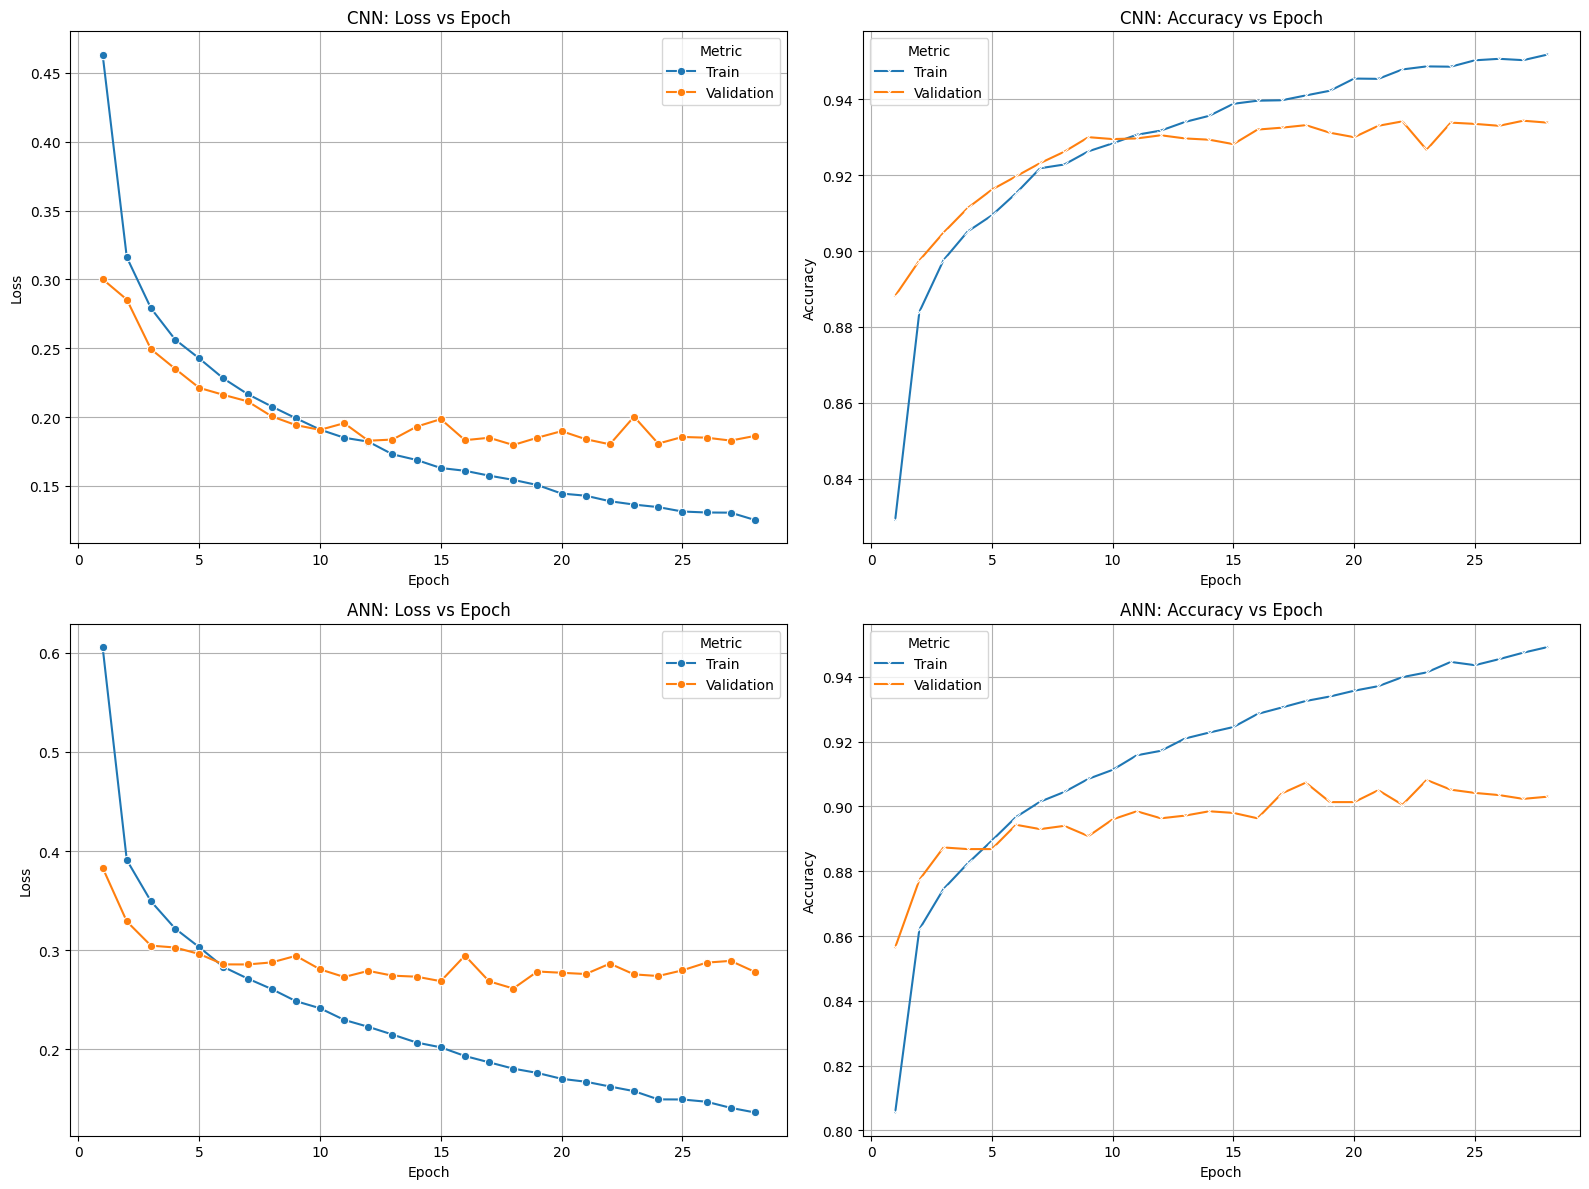

In [ ]:
# Training graph visualization
 
cnnDf = pd.DataFrame({
    "Epoch": list(range(1, len(CNNTrainLossHistory)+1))*2,
    "Metric": ["Train"]*len(CNNTrainLossHistory) + ["Validation"]*len(CNNValLossHistory),
    "Loss": CNNTrainLossHistory + CNNValLossHistory,
    "Model": "CNN"
})

cnnAccDf = pd.DataFrame({
    "Epoch": list(range(1, len(CNNTrainAccHistory)+1))*2,
    "Metric": ["Train"]*len(CNNTrainAccHistory) + ["Validation"]*len(CNNValAccHistory),
    "Accuracy": CNNTrainAccHistory + CNNValAccHistory,
    "Model": "CNN"
})

annDf = pd.DataFrame({
    "Epoch": list(range(1, len(ANNTrainLossHistory)+1))*2,
    "Metric": ["Train"]*len(ANNTrainLossHistory) + ["Validation"]*len(ANNValLossHistory),
    "Loss": ANNTrainLossHistory + ANNValLossHistory,
    "Model": "ANN"
})

annAccDf = pd.DataFrame({
    "Epoch": list(range(1, len(ANNTrainAccHistory)+1))*2,
    "Metric": ["Train"]*len(ANNTrainAccHistory) + ["Validation"]*len(ANNValAccHistory),
    "Accuracy": ANNTrainAccHistory + ANNValAccHistory,
    "Model": "ANN"
})

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# CNN Loss
sns.lineplot(data=cnnDf, x="Epoch", y="Loss", hue="Metric", marker="o", ax=axes[0,0])
axes[0,0].set_title("CNN: Loss vs Epoch")
axes[0,0].grid(True)

# CNN Accuracy
sns.lineplot(data=cnnAccDf, x="Epoch", y="Accuracy", hue="Metric", marker="x", ax=axes[0,1])
axes[0,1].set_title("CNN: Accuracy vs Epoch")
axes[0,1].grid(True)

# ANN Loss
sns.lineplot(data=annDf, x="Epoch", y="Loss", hue="Metric", marker="o", ax=axes[1,0])
axes[1,0].set_title("ANN: Loss vs Epoch")
axes[1,0].grid(True)

# ANN Accuracy
sns.lineplot(data=annAccDf, x="Epoch", y="Accuracy", hue="Metric", marker="x", ax=axes[1,1])
axes[1,1].set_title("ANN: Accuracy vs Epoch")
axes[1,1].grid(True)

plt.tight_layout()
plt.show()


The 4 graphs show that the CNN has minimal overfitting throughout and training and validation metrics are quite similar with only a slight amount of overfitting

The ANN model has more overfitting which starts earlier as would be expected

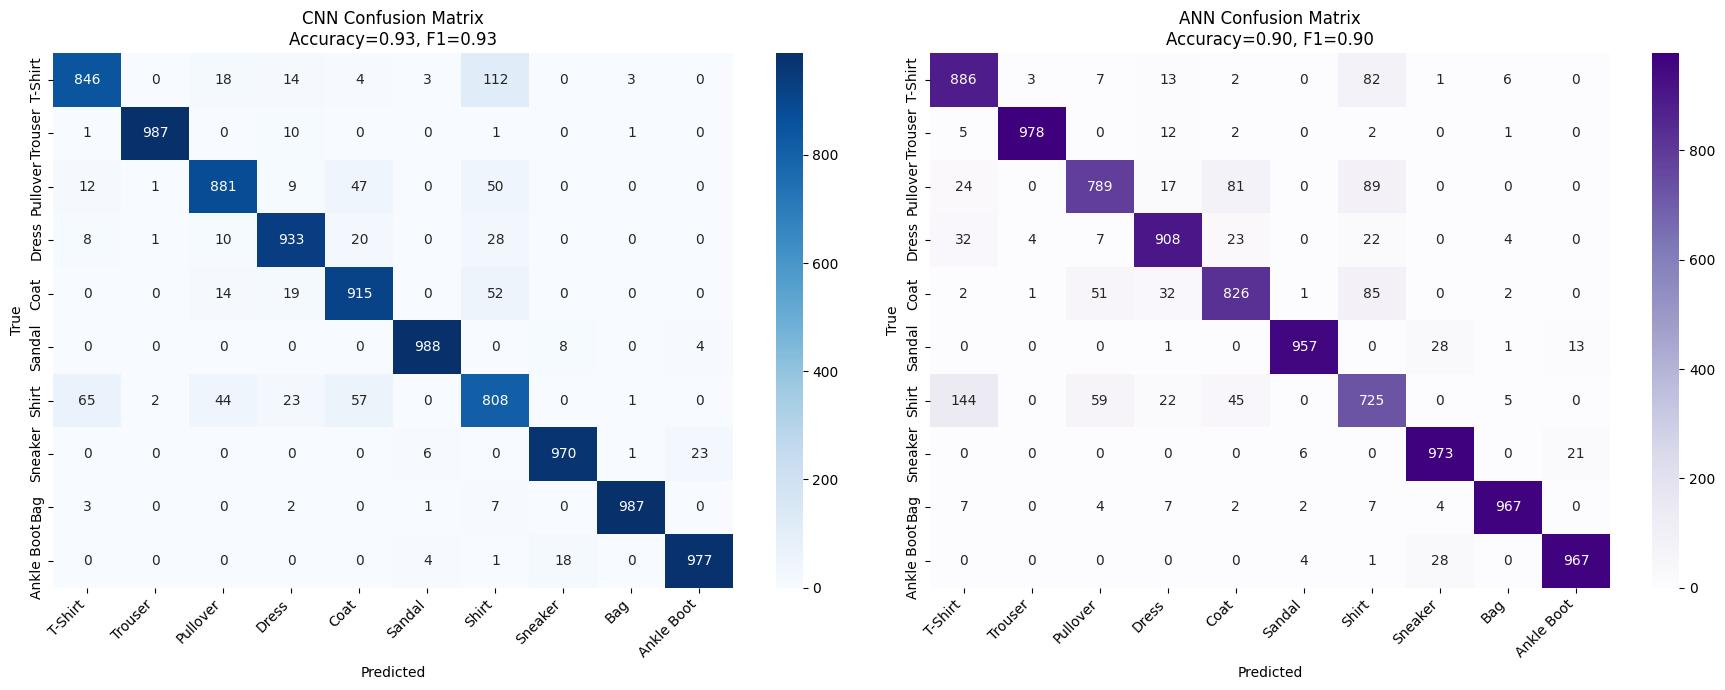

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

classLabels = [classNames[i] for i in range(len(classNames))]

# Confusion matrices
CNNHeatMap = confusion_matrix(CNNAllLabels, CNNAllPreds)
ANNHeatMap = confusion_matrix(ANNAllLabels, ANNAllPreds)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# CNN
sns.heatmap(
    CNNHeatMap, annot=True, fmt='d', cmap='Blues',
    xticklabels=classLabels, yticklabels=classLabels, ax=axes[0]
)
axes[0].set_title(f'CNN Confusion Matrix\nAccuracy={CNNAccuracy:.2f}, F1={CNNF1:.2f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# ANN
sns.heatmap(
    ANNHeatMap, annot=True, fmt='d', cmap='Purples',
    xticklabels=classLabels, yticklabels=classLabels, ax=axes[1]
)
axes[1].set_title(f'ANN Confusion Matrix\nAccuracy={ANNAccuracy:.2f}, F1={ANNF1:.2f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


The confusion matrix shows the main problem with these two models. Due to the limitation of both the CNN and ANN models as well as the Fashion-MNIST dataset being relativly small and containing fairly simple 28*28 pixel greyscale images, the models struggle to differentiate between certian classes notably a T-shirt and a shirt. 

This could be addressed through either the use of a more complex model such as a Vision Transformer whihc could allow it to capture more subtle patterns from the data, or having a larger data pool such as using a GAN to generate more data. However a GAN could run into the same issues as these two models where it struggles between the T-shirt and shirt images thus not improving the CNN and ANN models much.

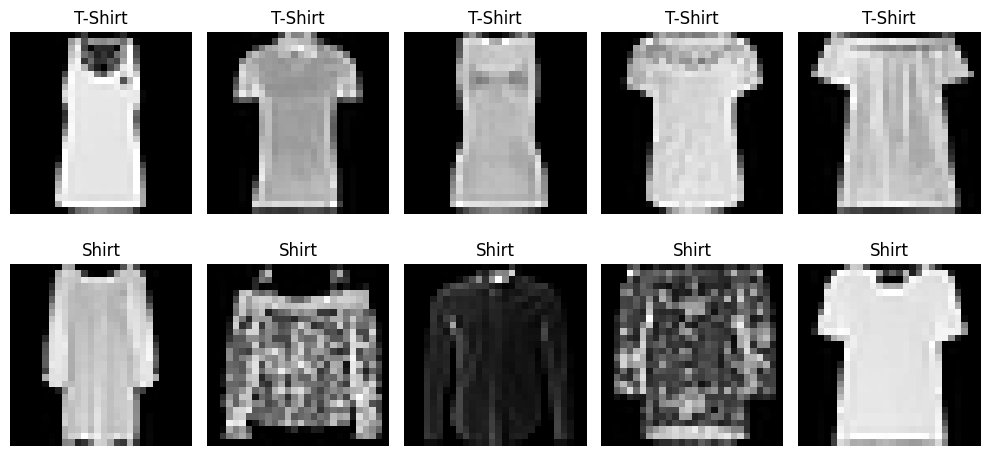

In [ ]:
import matplotlib.pyplot as plt
import random

tshirtClass = 0
shirtClass = 6
numSamples = 5

# Get indices for T-Shirt and Shirt classes
tshirtIndices = [i for i, (_, label) in enumerate(testData) if label == tshirtClass]
shirtIndices = [i for i, (_, label) in enumerate(testData) if label == shirtClass]

# Sample 5 random indices from each (or fewer if less than 5 available)
tshirtSamples = random.sample(tshirtIndices, min(numSamples, len(tshirtIndices)))
shirtSamples = random.sample(shirtIndices, min(numSamples, len(shirtIndices)))

# Plotting
fig, axes = plt.subplots(2, numSamples, figsize=(numSamples * 2, 5))

for i, idx in enumerate(tshirtSamples):
    img, label = testData[idx]
    axes[0, i].imshow(img.squeeze(), cmap='gray')
    axes[0, i].set_title("T-Shirt")
    axes[0, i].axis('off')

for i, idx in enumerate(shirtSamples):
    img, label = testData[idx]
    axes[1, i].imshow(img.squeeze(), cmap='gray')
    axes[1, i].set_title("Shirt")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


This shows how similar some of the images in the T-Shirt and shirt classes can be in this dataset, showing how difficult it would be for a model to learn to differentiate between them.